## Load and Examine Data

In [16]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.gridspec as gridspec
import os


In [2]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(64,64))

In [60]:
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data(one_hot=True)
X = X.reshape([-1, 28, 28])
Y = Y.astype(float)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [4]:
print X.shape
print Y.shape

(55000, 28, 28)
(55000, 10)


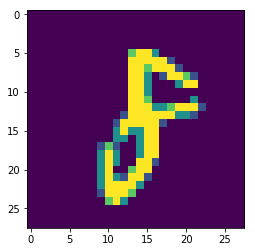

In [5]:
plt.imshow(X[30])

In [61]:
Y[0,]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

## GAN

In [98]:
# Hyperparameters
mb_size = 128
num_epochs = 30
Z_dim = 30
image_size = 28
label_size = Y.shape[1]
D_learning_rate = 0.001
G_learning_rate = 0.0005

In [91]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28))

    return fig

def generate_a_graph(i,j): # generate image by label
    label_index = (i)*5+(j)
    label_y = np.random.uniform(0, 0, size=[1, label_size])
    label_y[0,label_index] = 1 # so that we will know which graph should show what number

    z = np.random.uniform(-1., 1., size=[1, Z_dim])
    g = sess.run(G_sample, feed_dict={Z_ph: z, Y_real:label_y})
    return (g.reshape(image_size, image_size))

In [88]:
# Construct the conditional GAN

tf.reset_default_graph()

def xavier_init(size):
    return tf.random_normal(shape=size, stddev=(1. / tf.sqrt(size[0] / 2.)))

def generator(z, y):
    z_y = tf.concat([z, y], 1)
    G_h1 = tf.nn.relu(tf.matmul(z_y, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

def discriminator(x, y):
    x_y = tf.concat([x, y], 1)
    D_h1 = tf.nn.relu(tf.matmul(tf.contrib.layers.flatten(x_y), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit


# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, (image_size*image_size)], name='X')
Y_real = tf.placeholder(tf.float32, shape=[None, label_size], name='Y_real')

D_W1 = tf.Variable(xavier_init([(image_size*image_size+label_size), 128]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')

D_W2 = tf.Variable(xavier_init([128, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]


# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

G_W1 = tf.Variable(xavier_init([Z_dim+label_size, 128]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')

G_W2 = tf.Variable(xavier_init([128, (image_size*image_size) ]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[(image_size*image_size)]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]


# losses and MaxMin
G_sample = generator(Z_ph, Y_real)
D_real, D_logit_real = discriminator(X_ph, Y_real)
D_fake, D_logit_fake = discriminator(G_sample,Y_real)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer(D_learning_rate,beta1=0.5).minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer(G_learning_rate,beta1=0.5).minimize(G_loss, var_list=theta_G)



In [89]:
def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

def batch_iter(data, label, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
            shuffled_label = label[shuffle_indices]
        else:
            shuffled_data = data
            shuffled_label = label
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield (shuffled_data[start_index:end_index], shuffled_label[start_index:end_index])

Iter: 1
D loss: 1.598
G_loss: 0.5117
()


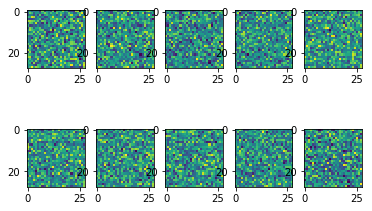

Iter: 3000
D loss: 0.3343
G_loss: 3.819
()


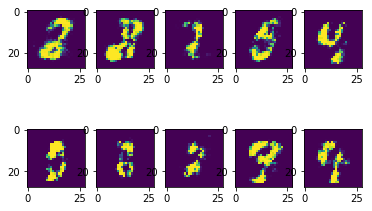

Iter: 6000
D loss: 0.58
G_loss: 2.597
()


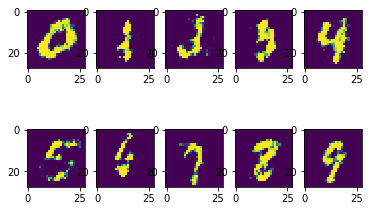

Iter: 9000
D loss: 0.3615
G_loss: 3.26
()


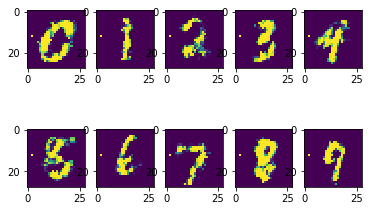

Iter: 12000
D loss: 0.48
G_loss: 2.393
()


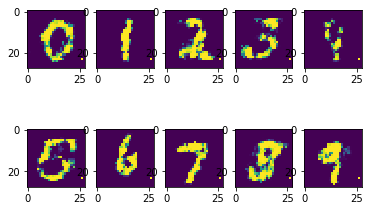

In [99]:
## Run the conditional GAN model

# define global steps 
global_step = tf.Variable(0, name="global_step", trainable=False)
incr_global_step_op = tf.assign(global_step, global_step+1)

# start tf session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

# initialize loss
D_loss_c = []
G_loss_c = []

# Run in mini batch
batches = batch_iter(X, Y, mb_size, num_epochs)

for image, label in batches:
    
    _, D_loss_curr, _, G_loss_curr, i = sess.run([D_solver, D_loss, G_solver, G_loss, incr_global_step_op]
                                                 ,feed_dict={X_ph: image.reshape([-1,(image_size*image_size)])
                                                             , Y_real: label
                                                             , Z_ph:sample_Z(image.shape[0], Z_dim)
                                                             })
    # print some loss during the training
    if i % 3000 == 0 or i==1:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        D_loss_c.append(D_loss_curr)
        G_loss_c.append(G_loss_curr)
        
    # generate plot with set label during the training    
    if i % 3000 == 0 or i==1:
        f, axarr = plt.subplots(2,5)
        for n in range(2):
            for m in range(5):
                im = generate_a_graph(n,m)
                axarr[n,m].imshow(im)
        plt.show()